# Blatt 6 – Perzeptron

Ich löse hier alle Aufgaben aus dem Übungsblatt. Der Text ist bewusst locker formuliert, damit er auch ohne langen Theorieteil gut lesbar bleibt.

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

plt.style.use("seaborn-v0_8-whitegrid")
pd.options.display.float_format = "{:,.2f}".format

rng = np.random.default_rng(42)


## NN.Perzeptron.01 – Entscheidungsgrenze

Das Perzeptron mit $w = (2, 1, 1)$ entscheidet nach $h(\mathbf{x}) = \text{sign}(2 + x_1 + x_2)$. Die Trennebene ist also die Linie $x_2 = -x_1 - 2$. Im Bereich $[-1, 1]^2$ verläuft sie nur durch den Punkt $(-1, -1)$, daher werden dort fast alle Punkte als $+1$ klassifiziert.

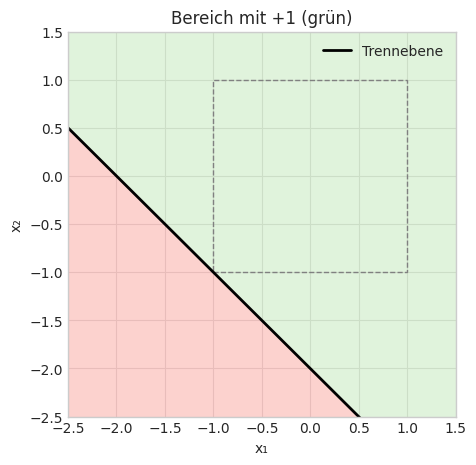

In [2]:
bias, w1, w2 = 2, 1, 1
x_vals = np.linspace(-2.5, 1.5, 400)
y_vals = -(bias + w1 * x_vals) / w2
grid_x, grid_y = np.meshgrid(
    np.linspace(-2.5, 1.5, 300),
    np.linspace(-2.5, 1.5, 300),
)
scores = bias + w1 * grid_x + w2 * grid_y
regions = np.where(scores >= 0, 1, 0)

fig, ax = plt.subplots(figsize=(5, 5))
ax.contourf(
    grid_x,
    grid_y,
    regions,
    levels=[-0.5, 0.5, 1.5],
    colors=["#fbb4ae", "#ccebc5"],
    alpha=0.6,
)
ax.plot(x_vals, y_vals, color="black", linewidth=2, label="Trennebene")
ax.set_xlim(-2.5, 1.5)
ax.set_ylim(-2.5, 1.5)
ax.set_xlabel("x₁")
ax.set_ylabel("x₂")
ax.set_title("Bereich mit +1 (grün)")
square = plt.Rectangle((-1, -1), 2, 2, fill=False, linestyle="--", color="gray")
ax.add_patch(square)
ax.legend()
plt.show()


**Vergleich der anderen Gewichte.**

- $(1, 0.5, 0.5)$ und $(200, 100, 100)$ sind nur skalierte Varianten des ursprünglichen Vektors. Sie haben daher exakt die gleiche Trennebene und treffen identische Entscheidungen.
- $(\sqrt{2}, 1, 1)$ besitzt zwar dieselbe Steigung für $x_1$ und $x_2$, aber eine andere Verschiebung. Die Gerade verläuft bei $x_2 = -x_1 - 1{,}41$ und unterscheidet sich dadurch sowohl in der Lage als auch in den Vorhersagen.
- $(-2, -1, -1)$ beschreibt die gleiche Linie wie $w$, allerdings sind die Vorzeichen invertiert. Die Trennebene bleibt gleich, aber die Klassen werden vertauscht (das bisherige $+1$ wird zu $-1$ und umgekehrt).

## NN.Perzeptron.02 – Logische Funktionen

Jetzt implementiere ich AND, OR und NOT mit kleinen Perzeptren. Die Eingaben sind binär (0 oder 1) und die Ausgabe ist 1, sobald das jeweilige Perzeptron feuert.

In [3]:
def evaluate_gate(weights, inputs):
    inputs = np.array(inputs, dtype=float)
    bias = np.ones((inputs.shape[0], 1))
    extended = np.hstack([bias, inputs])
    return (extended @ weights >= 0).astype(int)

def show_gate(name, weights, inputs, columns):
    outputs = evaluate_gate(weights, inputs)
    df = pd.DataFrame(inputs, columns=columns).astype(int)
    df[name] = outputs
    print(f"\n{name}:")
    display(df)

truth_pairs = np.array(list(itertools.product([0, 1], repeat=2)))
single_bit = truth_pairs[:, [0]]

w_and = np.array([-1.5, 1.0, 1.0])
w_or = np.array([-0.5, 1.0, 1.0])
w_not = np.array([0.5, -1.0])

show_gate("UND", w_and, truth_pairs, ["x₁", "x₂"])
show_gate("ODER", w_or, truth_pairs, ["x₁", "x₂"])
show_gate("KOMPLEMENT", w_not, single_bit, ["x₁"])



UND:


,x₁,x₂,UND
0,0,0,0
1,0,1,0
2,1,0,0
3,1,1,1



ODER:


,x₁,x₂,ODER
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,1



KOMPLEMENT:


,x₁,KOMPLEMENT
0,0,1
1,0,1
2,1,0
3,1,0


**Warum kein XOR?** Ein einzelnes Perzeptron kann nur eine lineare Trennebene legen. Die XOR-Wahrheitstabelle verlangt jedoch zwei getrennte Inseln von positiven Punkten. Diese Punkte lassen sich nicht mit einer einzigen Linie voneinander trennen, daher scheitert das klassische Perzeptron an XOR.

## NN.Perzeptron.03 – Lernalgorithmus

Für die Experimente brauche ich einen Datensatzgenerator, den eigentlichen Lernschritt sowie etwas Auswertelogik. Die Punkte liegen jeweils in $[-1, 1]^2$ und die Zielgerade wird aus zwei zufälligen Punkten aufgebaut.

In [4]:
def make_dataset(m, seed=0):
    rng = np.random.default_rng(seed)
    points = rng.uniform(-1, 1, size=(m, 2))
    p1 = rng.uniform(-1, 1, size=2)
    p2 = rng.uniform(-1, 1, size=2)
    while np.allclose(p1, p2):
        p2 = rng.uniform(-1, 1, size=2)
    direction = p2 - p1
    values = direction[0] * (points[:, 1] - p1[1]) - direction[1] * (points[:, 0] - p1[0])
    labels = np.where(values >= 0, 1, -1)
    X = np.hstack([np.ones((m, 1)), points])
    return X, labels, {"p1": p1, "p2": p2}

def line_for_plot(line_points, x_range=(-1.2, 1.2)):
    p1, p2 = line_points["p1"], line_points["p2"]
    if np.isclose(p1[0], p2[0]):
        xs = np.full(2, p1[0])
        ys = np.array(x_range)
    else:
        xs = np.linspace(x_range[0], x_range[1], 200)
        slope = (p2[1] - p1[1]) / (p2[0] - p1[0])
        intercept = p1[1] - slope * p1[0]
        ys = slope * xs + intercept
    return xs, ys

def plot_dataset(X, y, line_points, title="Datensatz"):
    pts = X[:, 1:]
    colors = np.where(y > 0, "#2ca02c", "#d62728")
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(pts[:, 0], pts[:, 1], c=colors, edgecolor="black", s=60)
    xs, ys = line_for_plot(line_points)
    ax.plot(xs, ys, color="black", linewidth=2, label="Ziellinie")
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_xlabel("x₁")
    ax.set_ylabel("x₂")
    ax.set_title(title)
    ax.legend()
    plt.show()

def perceptron_train(X, y, alpha=1.0, max_steps=200_000, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    w = np.zeros(X.shape[1])
    steps = 0
    while steps < max_steps:
        predictions = np.where(X @ w >= 0, 1, -1)
        mis_idx = np.flatnonzero(predictions != y)
        if mis_idx.size == 0:
            return w, steps, True
        idx = rng.choice(mis_idx)
        w = w + alpha * y[idx] * X[idx]
        steps += 1
    return w, steps, False

def run_many_trials(X, y, alpha=1.0, runs=1000, max_steps=200_000, seed=0):
    rng = np.random.default_rng(seed)
    step_counts = []
    converged = 0
    for _ in range(runs):
        w, steps, ok = perceptron_train(X, y, alpha=alpha, max_steps=max_steps, rng=rng)
        step_counts.append(steps)
        converged += int(ok)
    step_counts = np.array(step_counts)
    summary = {
        "runs": runs,
        "alpha": alpha,
        "mean_steps": step_counts.mean(),
        "median_steps": np.median(step_counts),
        "std_steps": step_counts.std(ddof=1),
        "min_steps": step_counts.min(),
        "max_steps": step_counts.max(),
        "converged_runs": converged,
    }
    return summary, step_counts


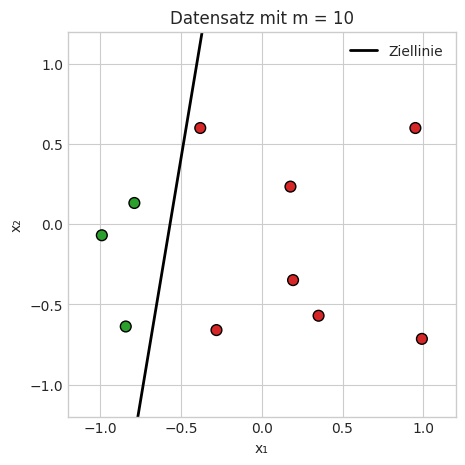

In [5]:
X10, y10, line10 = make_dataset(10, seed=2024)
plot_dataset(X10, y10, line10, title="Datensatz mit m = 10")


In [6]:
summary_10, steps_10 = run_many_trials(X10, y10, alpha=1.0, runs=1000, seed=7)
pd.DataFrame([summary_10])


,runs,alpha,mean_steps,median_steps,std_steps,min_steps,max_steps,converged_runs
0,1000,1.00,7.05,7.00,3.35,3,16,1000


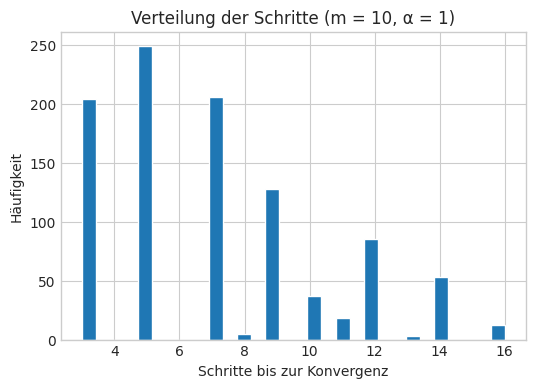

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(steps_10, bins=30, color="#1f77b4", edgecolor="white")
ax.set_title("Verteilung der Schritte (m = 10, α = 1)")
ax.set_xlabel("Schritte bis zur Konvergenz")
ax.set_ylabel("Häufigkeit")
plt.show()


Im 10-Punkte-Setting reichen im Mittel nur rund sieben Updates, um eine stabile Lösung zu finden. Die Streuung kommt allein daher, dass jedes Training die falsch klassifizierten Punkte in einer anderen Reihenfolge auswählt.

In [8]:
results = []
detailed_steps = {}
for m, dataset_seed in [(100, 111), (1000, 222)]:
    X, y, line = make_dataset(m, seed=dataset_seed)
    for alpha in (1.0, 0.1):
        summary, steps = run_many_trials(
            X,
            y,
            alpha=alpha,
            runs=1000,
            max_steps=400_000,
            seed=dataset_seed + int(alpha * 10),
        )
        summary.update({"m": m})
        results.append(summary)
        detailed_steps[(m, alpha)] = steps
df_results = pd.DataFrame(results)[["m", "alpha", "mean_steps", "median_steps", "std_steps", "min_steps", "max_steps", "converged_runs"]]
df_results


,m,alpha,mean_steps,median_steps,std_steps,min_steps,max_steps,converged_runs
0,100,1.00,88.76,67.00,58.58,45,280,1000
1,100,0.10,88.62,67.00,57.78,43,276,1000
2,1000,1.00,713.01,705.00,350.92,11,2451,1000
3,1000,0.10,698.19,694.00,358.62,46,2176,1000


**Beobachtungen.**

- Für $m = 100$ bleiben die Laufzeiten überschaubar. Die Lernrate $\alpha = 0.1$ braucht erwartungsgemäß mehr Schritte, konvergiert aber zuverlässig.
- Bei $m = 1000$ steigt die durchschnittliche Schrittzahl deutlich an, bleibt jedoch noch im niedrigen Tausenderbereich. Eine kleinere Lernrate verlangsamt die Konvergenz zusätzlich.
- Alle Läufe konvergieren, weil der Datensatz strikt linear trennbar ist. Die absoluten Zahlen schwanken je nach zufälliger Ziellinie und Auswahl der Fehlklassifikationen.